# Digit Classifier

This notebook will serve as a model development notebook

In [24]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Preliminary Data Work (Exploration, Preparation, etc.)

In [25]:
# Getting the data
full_data = pd.read_csv('/Users/jinalshah/Jinal/Github Repos/Digit-Classifier/Data/train.csv')
full_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Image Label 0
Image:


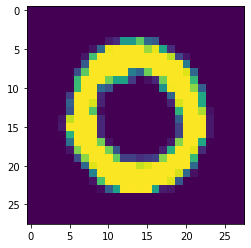

In [26]:
# Plotting an image to see what it looks like
print(f'Image Label {full_data["label"][1]}')
print('Image:')
plt.imshow(full_data.drop('label',axis=1).values[1].reshape(28,28))
plt.show()

In [27]:
# Converting data into a numpy array
full_data = full_data.values
full_data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [28]:
# Splitting data into training & testing
train_data, test_data = train_test_split(full_data, test_size=0.2,random_state=0, shuffle=True)

In [29]:
# Splitting data into training & validation
train_data, valid_data = train_test_split(train_data, test_size=0.2,random_state=0, shuffle=True)

In [30]:
# Looking at the shapes of each dataset
print(f'Training Data Shape: {train_data.shape}')
print(f'Validation Data Shape: {valid_data.shape}')
print(f'Testing Data Shape: {test_data.shape}')

Training Data Shape: (26880, 785)
Validation Data Shape: (6720, 785)
Testing Data Shape: (8400, 785)


In [31]:
# Putting data into dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=224, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=224, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=120, shuffle=True)

## Model Building

In [32]:
# Building the Model
class Digit_Classifier(nn.Module):
    # Constructor
    def __init__(self):
        super().__init__()
        
        # Building the layers
        self.input_layer = nn.Linear(784, 500)
        self.hidden1 = nn.Linear(500, 250)
        self.hidden2 = nn.Linear(250, 128)
        self.hidden3 = nn.Linear(128, 100)
        self.hidden4 = nn.Linear(100, 64)
        self.output = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
    
    # Forward method
    def forward(self, x):
        out = x.view(-1, 784)
        out = out.float()
        out = self.dropout(F.relu(self.input_layer(out)))
        out = self.dropout(F.relu(self.hidden1(out)))
        out = self.dropout(F.relu(self.hidden2(out)))
        out = self.dropout(F.relu(self.hidden3(out)))
        out = self.dropout(F.relu(self.hidden4(out)))
        out = self.output(out)
        fin = nn.LogSoftmax(dim=1)
        return fin(out)

In [33]:
# Setting up for model training & validation
device = 'cuda' if torch.cuda.is_available() else 'cpu'    # Checking the device availability
model = Digit_Classifier()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train_loss = []
temp_train_loss = 0
train_accuracy = []
temp_train_accuracy = 0
valid_loss = []
temp_valid_loss = 0
valid_accuracy = []
temp_valid_accuracy = 0
epochs = 10

In [34]:
# Training the model
for i in range(epochs):
    temp_train_loss = 0
    temp_train_accuracy = 0
    temp_valid_loss = 0
    temp_valid_accuracy = 0
    
    model.train()
    # Training loop
    for images in train_loader:
        images.to(device)
        optimizer.zero_grad()
        logps = model(images[:,1:])
        loss = criterion(logps,images[:,0])
        temp_train_loss += loss
        loss.backward()
        optimizer.step()
        
        # Calculating training accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1,dim=1)
        equals = images[:,0] == top_class.view(*images[:,0].shape)
        equals = equals.float()
        temp_train_accuracy += torch.mean(equals)
    train_loss.append(temp_train_loss / len(train_loader))
    train_accuracy.append(temp_train_accuracy / len(train_loader))
    
    model.eval()
    # Validation Loop
    for images in valid_loader:
        images.to(device)
        logps = model(images[:,1:])
        loss = criterion(logps,images[:,0])
        temp_valid_loss += loss
        
        # Calculating validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1,dim=1)
        equals = images[:,0] == top_class.view(*images[:,0].shape)
        equals = equals.float()
        temp_valid_accuracy += torch.mean(equals)
    valid_loss.append(temp_valid_loss / len(valid_loader))
    valid_accuracy.append(temp_valid_accuracy / len(valid_loader))
    
    # Printing out the metrics
    print(f'Epoch {i} / {epochs}')
    print(f'Training Loss: {train_loss[i]}')
    print(f'Validation Loss: {valid_loss[i]}')
    print(f'Training Accuracy: {train_accuracy[i] * 100}%')
    print(f'Validation Accuracy: {valid_accuracy[i] * 100}%')
    print()

Epoch 0 / 10
Training Loss: 0.6713258624076843
Validation Loss: 0.24032242596149445
Training Accuracy: 79.14060974121094%
Validation Accuracy: 93.34822082519531%

Epoch 1 / 10
Training Loss: 0.2776212692260742
Validation Loss: 0.1812296211719513
Training Accuracy: 92.95013427734375%
Validation Accuracy: 95.14881134033203%

Epoch 2 / 10
Training Loss: 0.2295248657464981
Validation Loss: 0.1440015584230423
Training Accuracy: 94.24478149414062%
Validation Accuracy: 96.22024536132812%

Epoch 3 / 10
Training Loss: 0.22179415822029114
Validation Loss: 0.1664779931306839
Training Accuracy: 94.5759048461914%
Validation Accuracy: 96.13093566894531%

Epoch 4 / 10
Training Loss: 0.18602009117603302
Validation Loss: 0.16283853352069855
Training Accuracy: 95.46505737304688%
Validation Accuracy: 96.08631896972656%

Epoch 5 / 10
Training Loss: 0.1671677976846695
Validation Loss: 0.18280090391635895
Training Accuracy: 95.87052154541016%
Validation Accuracy: 96.05655670166016%

Epoch 6 / 10
Training Lo

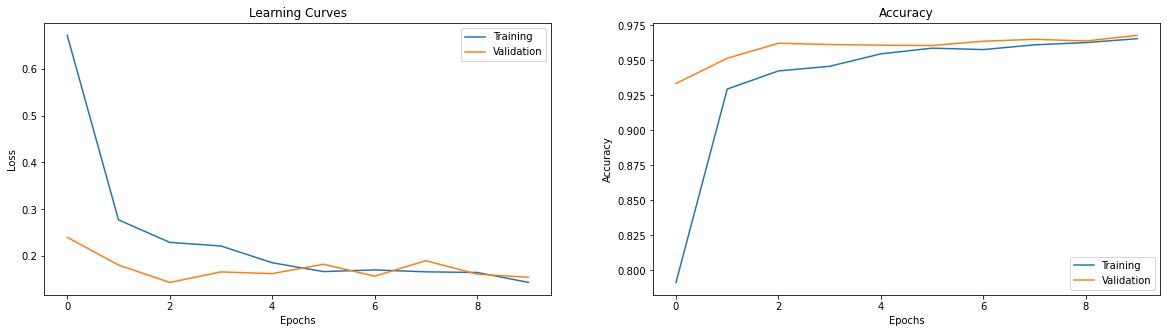

In [35]:
# Plotting the loss function learning curves & accuracy curves
figure = plt.figure()
figure.set_figheight(5)
figure.set_figwidth(20)
plt1, plt2 = figure.subplots(1,2)
plt1.set_title('Learning Curves')
plt1.set_xlabel('Epochs')
plt1.set_ylabel('Loss')
plt1.plot(train_loss,label='Training')
plt1.plot(valid_loss,label='Validation')
plt1.legend()
plt2.set_title('Accuracy')
plt2.set_xlabel('Epochs')
plt2.set_ylabel('Accuracy')
plt2.plot(train_accuracy,label='Training')
plt2.plot(valid_accuracy,label='Validation')
plt2.legend()
plt.show()

## Testing Model on Test Set

In [36]:
model.eval()
test_loss = 0
test_acc = 0

for images in test_loader:
    images.to(device)
    logps = model(images[:,1:])
    loss = criterion(logps, images[:,0])
    test_loss += loss
    
    # Accuracy
    prob = torch.exp(logps)
    _, top_class = prob.topk(1,dim=1)
    equals = images[:,0] == top_class.view(*images[:,0].shape)
    equals = equals.float()
    test_acc += torch.mean(equals)
print(f'Test Loss: {test_loss / len(test_loader)}')
print(f'Test Accuracy: {test_acc / len(test_loader) * 100}')

Test Loss: 0.15502101182937622
Test Accuracy: 96.97618103027344


## Saving the Model Parameters

In [37]:
filepath = '/Users/jinalshah/Jinal/Github Repos/Digit-Classifier/Models/'
model_desc = {
    'Model':model,
    'weights & biases':model.state_dict(),
}

In [38]:
# Saving Model
torch.save(model_desc,filepath+'model2.pt')